In [45]:
import torch
from pathlib import Path, PosixPath


MAPLE_CKPT_DIR = Path(
    "checkpoints/reproduce"
)
data_root = Path("nete_format_data")
dataset = "yelp"
aspect_category_frequency_path = data_root / dataset / "1/aspect_category_frequency.csv"
reviews_path = data_root / dataset / "reviews.pickle"

## Get the word embeddings and aspect embeddings 
<!-- self.transformer.wte.weight (n_vocab, emsize) -->
<!-- .aspect_embeddings (naspect, emsize) -->


In [46]:
import pickle
import pandas as pd


def load_model(checkpoint_dir: PosixPath):
    print(checkpoint_dir)
    with open(checkpoint_dir / "model.pt", "rb") as f:
        model = torch.load(f)
    return model


def load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

## Make a feature 2 category map

In [47]:
from collections import defaultdict

data = load_pickle(reviews_path)
cat2feat = defaultdict(set)
feat2cat = dict()
all_feats = set()
df = pd.read_csv(aspect_category_frequency_path)
cat2id = {cat: id for id, cat in zip(df["index"], df["category"])}
id2cat = {id: cat for id, cat in zip(df["index"], df["category"])}
for d in data:
    for f, _, _, _, cat in d["triplets"]:
        feat2cat[f] = (cat, cat2id[cat])
        if len(cat2feat[cat]) < 1000:
            cat2feat[cat].add(f)
            all_feats.add(f)

In [48]:
print(len(all_feats))
for cat in cat2feat:
    print(cat, "included feat:", len(cat2feat[cat]))

17115
food:Comfort Food and Diners included feat: 1000
location included feat: 1000
food:Seafood included feat: 1000
service included feat: 1000
food:Latin American Cuisine included feat: 1000
food:Greek and Mediterranean Cuisine included feat: 1000
food:Asian Cuisine included feat: 1000
food:Breakfast and Cafes included feat: 1000
food:American Cuisine included feat: 1000
food:Gluten-Free,Vegan,Vegetarian included feat: 1000
food:Middle Eastern Cuisine included feat: 1000
food:Live/Raw Food and Salad included feat: 1000
food:European Cuisine included feat: 1000
food:Chinese Cuisine included feat: 1000
food:Bars included feat: 1000
food:Japanese and Sushi included feat: 1000
food:Korean Cuisine included feat: 1000
food:Barbecue and Steakhouses included feat: 115


In [57]:
from transformers import GPT2Tokenizer
import sys

bos = "<bos>"
eos = "<eos>"
pad = "<pad>"

# For the pickled model to be loadable, we need to add the path to the module
sys.path.append("./recommender/")
tokenizer = GPT2Tokenizer.from_pretrained(
    "gpt2",
    bos_token=bos,
    eos_token=eos,
    pad_token=pad,
)

model = load_model(MAPLE_CKPT_DIR / dataset / "1")
model.eval()
aspect_embeddings = model.aspect_embeddings.weight.detach().cpu().numpy()
word_embeddings = model.transformer.wte.weight.detach().cpu().numpy()
print(aspect_embeddings.shape)
print(word_embeddings.shape)

/home/P76114511/micromamba/envs/mmcv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


/home/P76114511/projects/aspect_retriever/checkpoints/dbloss_nomerged_noff/yelp/1
(18, 768)
(50260, 768)


In [11]:
# check tokenizer vocab
vocab = tokenizer.get_vocab()
vocab_size = len(vocab)
assert vocab_size == word_embeddings.shape[0]

In [51]:
import torch
import numpy as np


def get_word_embedding(model, tokenizer, word):
    # Tokenize the word
    tokenized_text = tokenizer.tokenize(word)

    # Convert tokenized text to token IDs
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    # Get the GPT-2 model's embedding matrix
    embedding_matrix = model.transformer.wte.weight

    # Initialize an empty list to store embeddings
    embeddings = []

    # Get embeddings for each token
    try:
        for token_id in indexed_tokens:
            embedding_vector = embedding_matrix[token_id]
            embeddings.append(embedding_vector)
        return embeddings[-1].detach().cpu().numpy()
    except IndexError:
        print(f"Token {word} not in vocabulary")
        return np.zeros(768)

    # return averaged_embedding


# Example usage
word = "pizza"
embedding = get_word_embedding(model, tokenizer, word)
# print(embedding)

In [52]:
id2feat = list(all_feats)
feat2id = {feat: id for id, feat in enumerate(id2feat)}
fid2embedding = {
    feat2id[feat]: get_word_embedding(model, tokenizer, feat) for feat in all_feats
}

Token  not in vocabulary


In [53]:
feature_embeddings = np.array([fid2embedding[i] for i in range(len(id2feat))])
print(feature_embeddings.shape)

(17115, 768)


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity


def find_top_neighbors(aspect_embeddings, feature_embeddings, top_k=20):
    cos_sim = cosine_similarity(aspect_embeddings, feature_embeddings)
    top_neighbors = np.argsort(-cos_sim, axis=1)[:, :top_k]
    return top_neighbors

In [55]:
# Create a list of all embeddings to perform t-SNE
all_embeddings = np.vstack([aspect_embeddings, feature_embeddings])
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(all_embeddings)

In [105]:
naspect = aspect_embeddings.shape[0]
aspect_tsne = tsne_results[:naspect]
feat_tsne = tsne_results[naspect:]
top_neighbors = find_top_neighbors(aspect_tsne, feat_tsne, top_k=20)

In [119]:
tail_classes = df["index"].values[-5:]
head_classes = df["index"].values[:5]
tail_classes
print(df)

    index                              category   count
0       6          food:Comfort Food and Diners  270316
1      17                               service  184919
2      16                              location  170347
3       0                 food:American Cuisine   98491
4       1                    food:Asian Cuisine   69488
5       7                 food:European Cuisine   56609
6       9  food:Greek and Mediterranean Cuisine   38080
7      15                          food:Seafood   34523
8      12           food:Latin American Cuisine   27465
9       8     food:Gluten-Free,Vegan,Vegetarian   20885
10     13          food:Live/Raw Food and Salad   15294
11      4              food:Breakfast and Cafes   11554
12     10               food:Japanese and Sushi   10464
13     14           food:Middle Eastern Cuisine   10314
14      3                             food:Bars    6709
15      5                  food:Chinese Cuisine    5559
16     11                   food:Korean Cuisine 

In [208]:
min_distance = 0.5
palette = plt.get_cmap("tab20c")
# https://matplotlib.org/stable/users/explain/colors/colormaps.html
H = head_classes.tolist()
T = tail_classes.tolist()


def plot_tsne(aspect_tsne, feature_tsne, top_neighbors):
    plt.figure(figsize=(10, 5))
    # same category has same color

    # Plot aspect embeddings
    for x, aspect_id in enumerate(df['index']):
        aspect_point = aspect_tsne[aspect_id]
        aspect_name = id2cat[aspect_id]
        color = palette(x)
        apx, apy = aspect_point
        # if aspect_id in tail_classes:
        #     # give it an edge color of black rim
        #     plt.scatter(apx, apy, c=color, label=f"{aspect_name}", marker="s", s=[100], edgecolors="black")
        # elif aspect_id in head_classes:
        #

        # Plot top-K feature neighbors
        for ix, neighbor_id in enumerate(top_neighbors[aspect_id]):
            feat_point = feature_tsne[neighbor_id]
            wpx, wpy = feat_point
            feature_name = id2feat[neighbor_id]
            # if ix < topx:
            #     plt.text(wpx + 2, wpy + 2, feature_name, fontsize=8, color=color)

            plt.scatter(wpx, wpy, c=color, marker="o")
            # if aspect_id in tail_classes:
            #     plt.scatter(wpx, wpy, c=color, alpha=0.6, marker="o", edgecolors="black")
            # elif aspect_id in head_classes:
            #     plt.scatter(wpx, wpy, c=color, alpha=0.6, marker="o", edgecolors="red")
        plt.scatter(
            apx,
            apy,
            c=color,
            label=f"{aspect_name}",
            marker="v",
            s=[100],
            edgecolors="black",
        )
    plt.legend(loc=(1.08, -0.1), prop={'size': 13})
    plt.show()

/tmp/ipykernel_46379/668695112.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(wpx, wpy, c=color, marker="o")
/tmp/ipykernel_46379/668695112.py:37: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


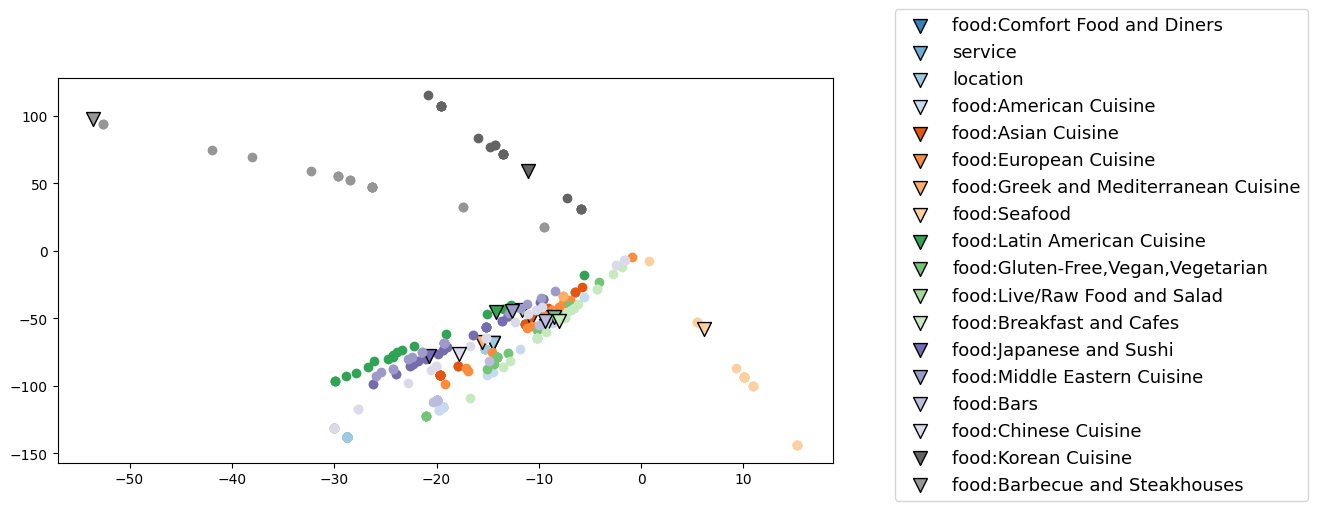

In [209]:
plot_tsne(aspect_tsne, feat_tsne, top_neighbors)